# Building classification model on CIFAR-10 multiclass dataset
It is based on the convolutional neural network implemented with PyTorch API.

In [43]:
## Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

## Device configuration and defining hyper parameters

In [44]:
# I am using GPU acceleration :)
device = torch.device('cuda')

# Hyper parameters
num_epochs = 10
batch_size = 40
learning_rate = 0.001

## Loading data

Firstly let's define a set of transformations which I will apply on images:

In [78]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

transform = transforms.Compose([transforms.RandomResizedCrop(32),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

Then creating a train and test dataset:

In [46]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

In [47]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

Some facts about loaded data:

In [59]:
classes = train_dataset.classes
classes_test = test_dataset.classes
assert len(classes) == len(classes_test), "Underrepresented classes!"

print(f"There are {len(classes)} classes:")
print(classes)

There are 10 classes:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [56]:
train_size = train_dataset.data.shape[0]
print(f"There are {train_size} examples in the training set.")

There are 50000 examples in the training set.


In [57]:
test_size = test_dataset.data.shape[0]
print(f"There are {test_size} examples in the test set.")

There are 10000 examples in the test set.


Defining data loaders:

In [60]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [61]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Visualisation of exemplary images:

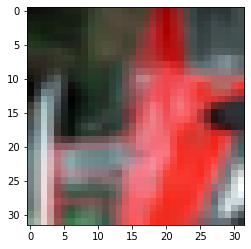

In [97]:
mini_batches = iter(train_loader)
mini_batch = next(mini_batches)
image = mini_batch[0][0].permute(2, 1, 0)
image = image.numpy()
inp = std * image + mean
inp = np.clip(inp, 0, 1)
image.shape
inp.shape
plt.imshow(inp)

In [96]:
image

array([[[ 0.06666672,  0.2941177 ,  0.7490196 ],
        [ 0.07450986,  0.30980396,  0.75686276],
        [ 0.09803927,  0.33333337,  0.7647059 ],
        ...,
        [ 0.48235297,  0.48235297,  0.49803925],
        [-0.0745098 , -0.0745098 , -0.05882353],
        [-0.3490196 , -0.35686272, -0.3333333 ]],

       [[ 0.07450986,  0.30196083,  0.75686276],
        [ 0.082353  ,  0.30980396,  0.75686276],
        [ 0.09803927,  0.33333337,  0.7647059 ],
        ...,
        [ 0.33333337,  0.32549024,  0.34901965],
        [-0.17647058, -0.18431371, -0.1607843 ],
        [-0.4352941 , -0.44313723, -0.41176468]],

       [[ 0.082353  ,  0.30980396,  0.7647059 ],
        [ 0.09019613,  0.3176471 ,  0.7647059 ],
        [ 0.10588241,  0.3411765 ,  0.77254903],
        ...,
        [-0.08235294, -0.09019607, -0.06666666],
        [-0.46666664, -0.47450978, -0.45098037],
        [-0.6627451 , -0.67058825, -0.6392157 ]],

       ...,

       [[ 0.09803927,  0.32549024,  0.77254903],
        [ 0

## Building CNN Model
Firstly I wil try training model from the begining. Two convolutional layers with maxpooling followed by fully connected 3 layers.

In [80]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #(in_channels, out_channels, kernel_size)
        self.pool = nn.MaxPool2d(2, 2) #
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   

In [81]:
# Model instantiation
model = ConvNet().to(device)

In [82]:
# Setting Loss function
criterion = nn.CrossEntropyLoss()

# Setting optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training Loop

In [83]:
n_total_steps = len(train_loader) # number of training mini-batches
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # mini-batch is sent to the device 
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_total_steps}, Loss: {loss.item():.4f}')

print('Training Finished. Hurraay!')

Epoch: 1/10, Step: 500/1250, Loss: 1.6062
Epoch: 1/10, Step: 1000/1250, Loss: 1.3311
Epoch: 2/10, Step: 500/1250, Loss: 1.5644
Epoch: 2/10, Step: 1000/1250, Loss: 1.1216
Epoch: 3/10, Step: 500/1250, Loss: 1.3293
Epoch: 3/10, Step: 1000/1250, Loss: 1.4173
Epoch: 4/10, Step: 500/1250, Loss: 1.0742
Epoch: 4/10, Step: 1000/1250, Loss: 1.3378
Epoch: 5/10, Step: 500/1250, Loss: 1.0384
Epoch: 5/10, Step: 1000/1250, Loss: 1.1379
Epoch: 6/10, Step: 500/1250, Loss: 1.3039
Epoch: 6/10, Step: 1000/1250, Loss: 0.9081
Epoch: 7/10, Step: 500/1250, Loss: 1.0259
Epoch: 7/10, Step: 1000/1250, Loss: 0.8653
Epoch: 8/10, Step: 500/1250, Loss: 1.0190
Epoch: 8/10, Step: 1000/1250, Loss: 1.0630
Epoch: 9/10, Step: 500/1250, Loss: 0.4741
Epoch: 9/10, Step: 1000/1250, Loss: 0.8329
Epoch: 10/10, Step: 500/1250, Loss: 1.1568
Epoch: 10/10, Step: 1000/1250, Loss: 0.9841
Training Finished. Hurraay!


### TEST

In [84]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc}%')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc}%')
                

Accuracy of the network: 63.67%
Accuracy of plane: 71.1%
Accuracy of car: 82.4%
Accuracy of bird: 55.9%
Accuracy of cat: 43.6%
Accuracy of deer: 56.7%
Accuracy of dog: 38.1%
Accuracy of frog: 73.1%
Accuracy of horse: 75.3%
Accuracy of ship: 72.4%
Accuracy of truck: 68.1%


## Building model by transfer learning
I am using pretrained ResNet18 model.

In [7]:
from torchsummary import summary

In [27]:
model = models.resnet18(pretrained=True).to(device)

In [28]:
input_size = (3, 32, 32)
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [31]:
# input size for the last fully connected layer. 
num_ftrs = model.fc.in_features
num_ftrs

512

In [35]:
# I assign new fully connected layer at the top of the ResNet18 model.
n_classes = len(classes)
model.fc = nn.Linear(num_ftrs, n_classes)
model = model.to(device)

In [37]:
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [38]:
# Now definition of criterion/loss function
criterion_RsN = nn.CrossEntropyLoss()

# and optimizer definition
optimizer_RsN = torch.optim.Adam(model.parameters(), lr=0.001)

# Updating learning rate by scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer_RsN, step_size=7, gamma=0.1)
# -> every 7 epochs learning rate is multiplied by gamma value

In [40]:
n_total_steps = len(train_loader) # number of training mini-batches
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # mini-batch is sent to the device 
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion_RsN(outputs, labels)
        
        # Backward and optimize
        optimizer_RsN.zero_grad()
        loss.backward()
        optimizer_RsN.step()
        
        if (i+1) % 500 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_total_steps}, Loss: {loss.item():.4f}')

print('Training Finished. Hurraay!')

Epoch: 1/10, Step: 500/1250, Loss: 1.0320
Epoch: 1/10, Step: 1000/1250, Loss: 0.9050
Epoch: 2/10, Step: 500/1250, Loss: 0.7939
Epoch: 2/10, Step: 1000/1250, Loss: 0.7465
Epoch: 3/10, Step: 500/1250, Loss: 0.5550
Epoch: 3/10, Step: 1000/1250, Loss: 0.5983
Epoch: 4/10, Step: 500/1250, Loss: 0.5494
Epoch: 4/10, Step: 1000/1250, Loss: 0.6097
Epoch: 5/10, Step: 500/1250, Loss: 0.3816
Epoch: 5/10, Step: 1000/1250, Loss: 0.1740
Epoch: 6/10, Step: 500/1250, Loss: 0.3619
Epoch: 6/10, Step: 1000/1250, Loss: 0.1413
Epoch: 7/10, Step: 500/1250, Loss: 0.1473
Epoch: 7/10, Step: 1000/1250, Loss: 0.2289
Epoch: 8/10, Step: 500/1250, Loss: 0.2712
Epoch: 8/10, Step: 1000/1250, Loss: 0.1283
Epoch: 9/10, Step: 500/1250, Loss: 0.2985
Epoch: 9/10, Step: 1000/1250, Loss: 0.1755
Epoch: 10/10, Step: 500/1250, Loss: 0.2019
Epoch: 10/10, Step: 1000/1250, Loss: 0.0719
Training Finished. Hurraay!


In [41]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc}%')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc}%')

Accuracy of the network: 79.1%
Accuracy of plane: 81.7%
Accuracy of car: 87.4%
Accuracy of bird: 74.2%
Accuracy of cat: 55.1%
Accuracy of deer: 81.6%
Accuracy of dog: 71.4%
Accuracy of frog: 83.6%
Accuracy of horse: 83.0%
Accuracy of ship: 86.2%
Accuracy of truck: 86.8%
